# N-gram distribution
Let's say we have two text samples of equal length (in tokens) - A and B. The question - Do bigrams (or n-grams)  present in A occur (on average) more or less frequently in B? Or as frequently?

On the face of it, it may seem that they _should_ occur at the same frequency.

But looking deeper, is this always the case? Similar n-grams are more likely to be found in proximity to each other. So n-grams in A should be (on average) more frequently found in A than in B.

But what if we create A and B from randomly sampling n-grams from a list of n-grams? Then the spatial adjacency is not really a concern.

Now is there another mathematical reason? There are almost certainly n-grams in B that do not exist in A. Thus there are some n-grams of frequency 0 in A that have a frequency > 0 in B. The total number of n-grams in B =number of ngrams in A. Therefore, on average, n-grams that are present in A must have a lower frequency  in B.

Are all n-grams equal? A decent starting hypothesis is that n-grams that encode common language features (e.g. stopwords) should be equally distributed across both, while n-grams that are less frequent are not.

### Dataset - Peter Norvig's Big Text File 
https://norvig.com/ngrams/
~1.2 mil tokens

In [68]:
import nltk
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [18]:
with open('big.txt', 'r') as myfile:
    text = myfile.read()

In [19]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
token=nltk.word_tokenize(text)
bigrams=ngrams(token,2)

In [20]:
bigrams = list(bigrams)

In [21]:
len(bigrams)

1288544

In [14]:
def get_bigram_frequencies(bigram_list):
    return Counter(bigram_list)

In [123]:
def get_bigram_frequency_in_holdout_set(bigram_freqs_a, bigram_freqs_holdout):
    """
    For all bigrams in set A, find the frequency in B/holdout set.
    returns a list of [(bigram, freq_in_a, freq_in_b)] for all bigrams in a.
    """
    new_bigram_counts = []
    for bigram, count in bigram_freqs_a.items():
        new_bigram_counts.append((bigram, count, bigram_freqs_holdout[bigram]))
    return new_bigram_counts
    

In [125]:
def aggregate_frequency_change_by_initial_frequency(bigram_freq_changes):
    """
    We want to know the frequency in the holdout set, given frequency in initial set.
    We aggregate by frequency in initial set to study whether initial frequency has an effect on frequency change.
    Return dict{initial_freq:new_freq}
    """
    new_frequency_aggregate = {} # freq in A : (total bigrams of that frequency, total count in B)
    for _, old_freq, new_freq in bigram_freq_changes:
        already_counted = new_frequency_aggregate.get(old_freq, (0,0))
        new_frequency_aggregate[old_freq] = (already_counted[0]+1, already_counted[1]+new_freq)
    
    for key, value in new_frequency_aggregate.items():
        new_frequency_aggregate[key] = value[1]/value[0]
    return new_frequency_aggregate
    

### Split the text sample down the middle.


In [126]:
sample_a_size = int(len(bigrams)/2)
sample_a = bigrams[:sample_a_size]
sample_b = bigrams[sample_a_size:]

In [127]:
sample_a_bigram_freqs = get_bigram_frequencies(sample_a)
sample_b_bigram_freqs = get_bigram_frequencies(sample_b)

In [128]:
frequency_changes = get_bigram_frequency_in_holdout_set(sample_a_bigram_freqs, sample_b_bigram_freqs)

In [129]:
aggregate_frequency_changes = aggregate_frequency_change_by_initial_frequency(frequency_changes)

Plotting functions

In [130]:
def plot_aggregate_frequency_changes(aggregate_frequency_change_list):
    x = np.array([i[0] for i in aggregate_frequency_change_list])
    y = np.array([i[1] for i in aggregate_frequency_change_list])
    colors = ['g' if x[i]>y[i] else 'r' for i in range(len(x))]
    plt.scatter(x, y, c=colors, s=5, linewidth=0)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    


In [131]:
def plot_all_freq_changes(aggregate_frequency_changes):
    print("Four separate plots to properly display different scale ranges")
    print("Green - more frequent in A. Red - more frequent in B")
    d_keys = sorted(aggregate_frequency_changes.keys())
    
    to_plot = []
    for i in d_keys[:100]:
        to_plot.append((i,aggregate_frequency_changes[i]))
    plot_aggregate_frequency_changes(to_plot)
    
    to_plot = []
    for i in d_keys[100:-50]:
        to_plot.append((i,aggregate_frequency_changes[i]))
    plot_aggregate_frequency_changes(to_plot)
    
    to_plot = []
    for i in d_keys[-50:-10]:
        to_plot.append((i,aggregate_frequency_changes[i]))
    plot_aggregate_frequency_changes(to_plot)
    
    to_plot = []
    for i in d_keys[-10:]:
        to_plot.append((i,aggregate_frequency_changes[i]))
    plot_aggregate_frequency_changes(to_plot)


Four separate plots to properly display different scale ranges
Green - more frequent in A. Red - more frequent in B


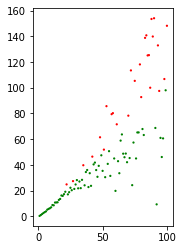

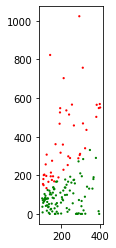

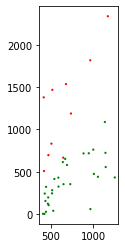

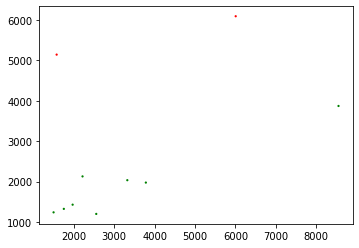

In [132]:
plot_all_freq_changes(aggregate_frequency_changes)

All our hypotheses seem to be confirmed in this test.

Among the least frequent bigrams, they are much more common in A than B. As we go toward more frequent ones, this trend changes, and the results are more mixed, though still skewed in the favour of A>B

### Splitting bigrams arbitrarily

In [117]:
from random import shuffle
shuffled_bigrams = bigrams.copy()
shuffle(shuffled_bigrams)

In [119]:
sample_a_size = int(len(shuffled_bigrams)/2)
sample_a = shuffled_bigrams[:sample_a_size]
sample_b = shuffled_bigrams[sample_a_size:]

In [120]:
sample_a_bigram_freqs = get_bigram_frequencies(sample_a)
sample_b_bigram_freqs = get_bigram_frequencies(sample_b)

frequency_changes = get_bigram_frequency_in_holdout_set(sample_a_bigram_freqs, sample_b_bigram_freqs)
aggregate_frequency_changes = aggregate_frequency_change_initial_frequency(frequency_changes)

Four separate plots to properly display different scale ranges
Green - more frequent in A. Red - more frequent in B


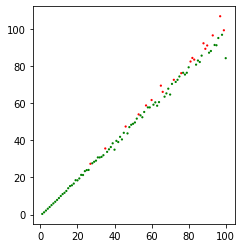

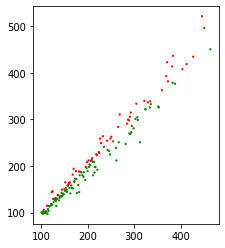

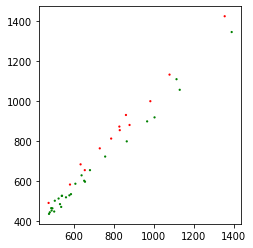

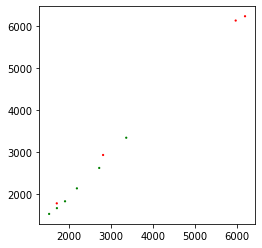

In [121]:
plot_all_freq_changes(aggregate_frequency_changes)

Again, for less frequently occuring bigrams, we see the same trend. The trend almost vanishes for more frequently occuring ones.